In [ ]:
#Preprocessing functions:


In [ ]:
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
def ppfft(f):
    #f is assumed N x N where N is even. If not, we just force it to be
    [h, w] = f.shape
    N = h
    f2 = f
    if h != w or np.mod(h, 2) == 1:
        N = int(np.ceil(max(h, w) / 2) * 2) #N is biggest dimension, but force even
        f2 = np.zeros([N, N])
        f2[N // 2 - int(h / 2):N // 2 - int(h / 2) + h, N // 2 - int(w / 2):N // 2 - int(w / 2) + w] = f
    ppff = np.zeros([2 * N, 2 * N]) * 1j

    #Constructing Quadrants 1 and 3
    ff = np.fft.fft(f2, N * 2, axis=0)
    ff = np.fft.fftshift(ff, 0)
    for i in range(-N, N):
        ppff[i + N, N - 1::-1] = fracfft(ff[i + N, :], i / (N ** 2), 1)

    #Constructing quadrants 2 and 4
    ff = np.fft.fft(f2, N * 2, axis=1)
    ff = np.fft.fftshift(ff, 1)
    ff = ff.T

    for i in range(-N, N):
        x = np.arange(0, N)
        factor = np.exp(1j * 2 * np.pi * x * (N / 2 - 1) * i / (N ** 2))
        ppff[i + N, N:2 * N] = fracfft(ff[i + N, :] * factor, i / (N ** 2))
    return ppff

In [ ]:
def fracfft(f, alpha, centered=0):
    f = np.reshape(f.T, f.size)#flatten f
    N = len(f)#get length

    if centered == 1:
        x = np.arange(0, N)
        factor = np.exp(1j * np.pi * x * N * alpha)
        f = f * factor

    x = np.append(np.arange(0, N), np.arange(-N, 0))
    factor = np.exp(-1j * np.pi * alpha * x ** 2)
    ff = np.append(f, np.zeros(N))
    ff = ff * factor
    XX = np.fft.fft(ff)
    YY = np.fft.fft(np.conj(factor))

    result = np.fft.ifft(XX * YY)
    result = result * factor
    result = result[0:N]
    return result

In [ ]:
import cv2

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
image = cv2.imread("/content/drive/MyDrive/signalfile/image.jpg")

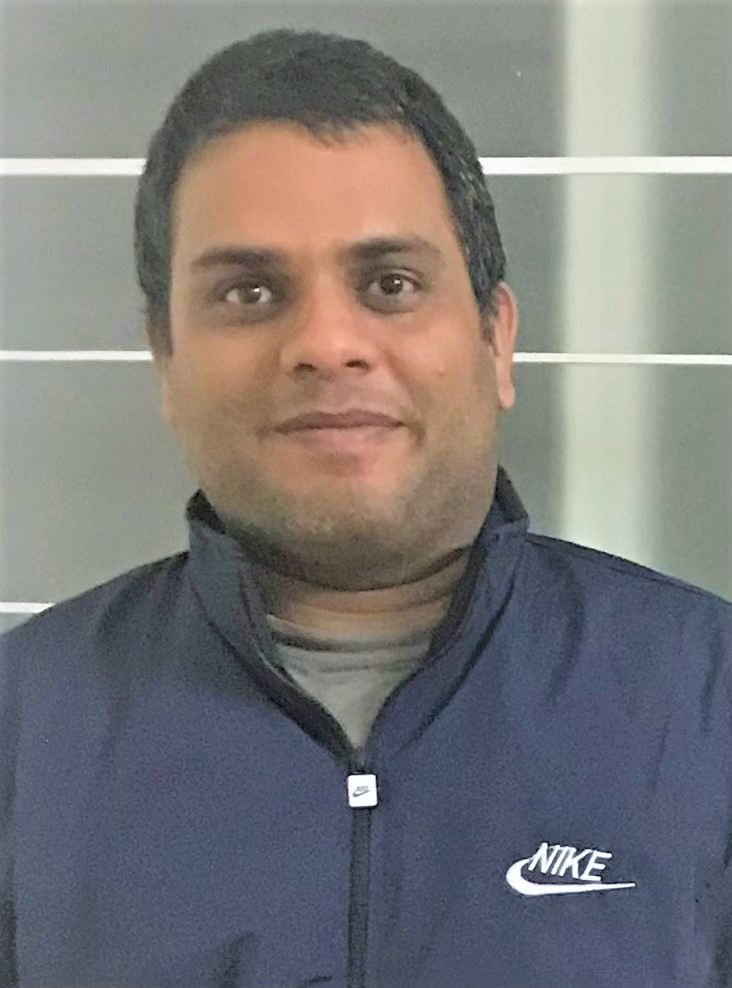

In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(image)


In [ ]:
f=image
f = cv2.cvtColor(f, cv2.COLOR_BGR2GRAY)
[h, w] = f.shape
print(h)
print(w)

988
732


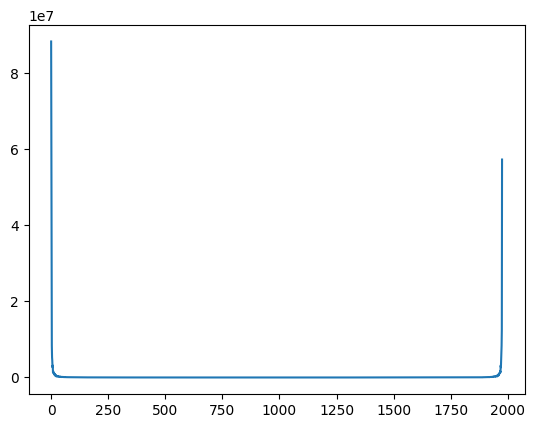

In [ ]:

ppff=ppfft(f)
meanppff = np.fft.fftshift(np.mean(np.abs(ppff), axis=1))
plt.plot(meanppff)

In [ ]:
points=[10, 15, 20, 25, 30, 35, 40, 45, 50]

num = np.asarray(points) * np.pi
points = num / np.round(len(meanppff) / 2)

W = f.shape[1]
H = f.shape[0]
points

array([0.0317975 , 0.04769624, 0.06359499, 0.07949374, 0.09539249,
       0.11129124, 0.12718999, 0.14308873, 0.15898748])

In [ ]:
def ewt_beta(x):
    bm = (x >= 0) * (x <= 1) \
        * (x ** 4 * (35 - 84 * x + 70 * x ** 2 - 20 *x **3))
    bm += (x > 1)
    return bm

In [ ]:

def ewt2d_LPscaling(radii, bound0, gamma):
    an = 1 / (2 * gamma * bound0)
    mbn = (1 - gamma) * bound0 # inner circle up to beginning of transtion
    pbn = (1 + gamma) * bound0 #end of transition

    scaling = 0 * radii #initiate w/ zeros
    scaling[radii < mbn] = 1
    scaling[radii >= mbn] = np.cos(np.pi * ewt_beta(an * (radii[radii >= mbn] - mbn)) / 2)
    scaling[radii > pbn] = 0
    return scaling

In [ ]:
def ewt2d_LPwavelet(radii, bound1, bound2, gamma):
    wan = 1 / (2 * gamma * bound1) #scaling factor
    wam = 1 / (2 * gamma * bound2)
    wmbn = (1 - gamma) * bound1 #beginning of lower transition
    wpbn = (1 + gamma) * bound1 #end of lower transition
    wmbm = (1 - gamma) * bound2  #beginning of upper transition
    wpbm = (1 + gamma) * bound2 #end of upper transition

    wavelet = 0 * radii #initialize w/ zeros
    inside = (radii > wmbn) * (radii < wpbm)
    wavelet[inside] = 1.0 #set entire angular wedge equal to 1
    temp = inside*(radii >= wmbm) * (radii <= wpbm) #upper transition
    wavelet[temp] *= np.cos(np.pi * ewt_beta(wam * (radii[temp] - wmbm)) / 2)
    temp = inside * (radii >= wmbn) * (radii <= wpbn) #lower transition
    wavelet[temp] *= np.sin(np.pi * ewt_beta(wan * (radii[temp] - wmbn)) / 2)
    return wavelet


In [ ]:
def ewt2d_LPFilterbank(bounds_scales, h, w):
    if h % 2 == 0:
        h += 1
        h_extended = 1
    else:
        h_extended = 0
    if w % 2 == 0:
        w += 1
        w_extended = 1
    else:
        w_extended = 0
    #First, we calculate gamma for scales
    gamma_scales = np.pi
    for k in range(0, len(bounds_scales) - 1):
        r = (bounds_scales[k + 1] - bounds_scales[k]) / (bounds_scales[k + 1] + bounds_scales[k])
        if r < gamma_scales and r > 1e-16:
            gamma_scales = r
    r = (np.pi - bounds_scales[-1]) / (np.pi + bounds_scales[-1]) #check last bound
    if r < gamma_scales and r > 1e-16:
        gamma_scales = r

    if gamma_scales > bounds_scales[0]:     #check first bound
        gamma_scales = bounds_scales[0]
    gamma_scales *= (1 - 1 / max(h, w)) #guarantees that we have strict inequality
    radii = np.zeros([h, w])

    h_center = h // 2 + 1
    w_center = w // 2 + 1
    for i in range(0, h):
        for j in range(0, w):
            ri = (i + 1.0 - h_center) * np.pi / h_center
            rj = (j + 1.0 - w_center) * np.pi / w_center
            radii[i, j] = np.sqrt(ri ** 2 + rj ** 2)

    mfb = []
    mfb.append(ewt2d_LPscaling(radii, bounds_scales[0], gamma_scales))
    for i in range(0, len(bounds_scales) - 1):
        mfb.append(ewt2d_LPwavelet(radii, bounds_scales[i], bounds_scales[i + 1], gamma_scales))
    mfb.append(ewt2d_LPwavelet(radii, bounds_scales[-1], 2 * np.pi, gamma_scales))

    if h_extended == 1: #if we extended the height of the image, trim
        h -= 1
        for i in range(0, len(mfb)):
            mfb[i] = mfb[i][0:-1, :]
    if w_extended == 1: #if we extended the width of the image, trim
        w -= 1
        for i in range(0, len(mfb)):
            mfb[i] = mfb[i][:, 0:-1]
    #invert the fftshift since filters are centered
    for i in range(0, len(mfb)):
        mfb[i] = np.fft.ifftshift(mfb[i])

    #Resymmetrize for even images
    if h_extended == 1:
        s = np.zeros(w)
        if w % 2 == 0:
            mfb[-1][h // 2, 1:w // 2] += mfb[-1][h // 2, -1:w // 2:-1]
            mfb[-1][h // 2, w // 2 + 1:] = mfb[-1][h // 2, w // 2 - 1:0:-1]
            s += mfb[-1][h // 2, :] ** 2
            #normalize for tight frame
            mfb[-1][h // 2, 1:w // 2] /= np.sqrt(s[1:w // 2])
            mfb[-1][h // 2, w // 2 + 1:] /= np.sqrt(s[w // 2 + 1:])
        else:
            mfb[-1][h // 2, 0:w // 2] += mfb[-1][h // 2, -1:w // 2:-1]
            mfb[-1][h // 2, w // 2 + 1:] = mfb[-1][h // 2, w // 2-1::-1]
            s += mfb[-1][h // 2, :] ** 2
            #normalize for tight frame
            mfb[-1][h // 2, 0:w // 2]  /= np.sqrt(s[0:w // 2])
            mfb[-1][h // 2, w // 2 + 1:] /= np.sqrt(s[w // 2 + 1:])
    if w_extended == 1:
        s = np.zeros(h)
        if h%2 == 0:
            mfb[-1][1:h // 2, w // 2] += mfb[-1][-1:h // 2:-1, w // 2]
            mfb[-1][h // 2 + 1:, w // 2] = mfb[-1][h // 2 - 1:0:-1, w // 2]
            s += mfb[-1][:, w // 2] ** 2
            #normalize for tight frame
            mfb[-1][1:h // 2, w // 2] /= np.sqrt(s[1:h // 2])
            mfb[-1][h // 2 + 1:, w // 2] /= np.sqrt(s[h // 2 + 1:])
        else:
            mfb[-1][0 : h // 2, w // 2] += mfb[-1][-1:h // 2:-1, w // 2]
            mfb[-1][h // 2 + 1:, w // 2] = mfb[-1][h // 2 - 1::-1, w // 2]
            s += mfb[-1][:, w // 2] ** 2
            #normalize for tight frame
            mfb[-1][0:h // 2, w // 2] /= s[0:h // 2]
            mfb[-1][h // 2 + 1:, w // 2] /= s[h // 2 + 1:]
    return mfb



In [ ]:
mfb = ewt2d_LPFilterbank(points, H, W)
#filter out coefficients
ff = np.fft.fft2(f)
ewtLP = [None] * len(mfb)
for k in range(len(mfb)):
    ewtLP[k] = np.real(np.fft.ifft2(np.conj(mfb[k]) * ff))

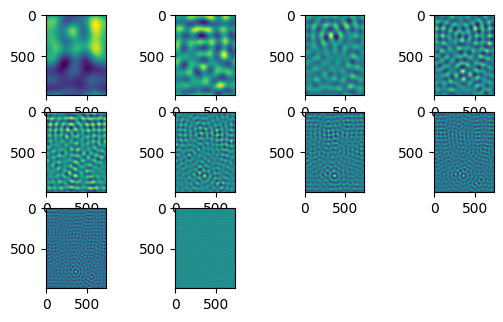

In [ ]:
plt.figure()
for m in range(len(mfb)):
    plt.subplot(4, 4, m+1)
    xx = ewtLP[m]
    plt.imshow(xx)

In [ ]:
#Loading Dataset:
!pip install -q kaggle


In [ ]:
%mkdir dataset
%mkdir dataset/images # for source images
%mkdir dataset/masks # for annotation masks
%mkdir dataset/test # for test images
%mkdir dataset/temp # temp storage


In [ ]:
# start the download
!kaggle datasets download 'nikhilpandey360/chest-xray-masks-and-labels'

In [ ]:
!unzip chest-xray-masks-and-labels.zip -d dataset/temp/


Archive:  chest-xray-masks-and-labels.zip
  inflating: dataset/temp/Lung Segmentation/.ipynb_checkpoints/Montgomery-checkpoint.ipynb  
  inflating: dataset/temp/Lung Segmentation/CXR_png/CHNCXR_0001_0.png  
  inflating: dataset/temp/Lung Segmentation/CXR_png/CHNCXR_0002_0.png  
  inflating: dataset/temp/Lung Segmentation/CXR_png/CHNCXR_0003_0.png  
  inflating: dataset/temp/Lung Segmentation/CXR_png/CHNCXR_0004_0.png  
  inflating: dataset/temp/Lung Segmentation/CXR_png/CHNCXR_0005_0.png  
  inflating: dataset/temp/Lung Segmentation/CXR_png/CHNCXR_0006_0.png  
  inflating: dataset/temp/Lung Segmentation/CXR_png/CHNCXR_0007_0.png  
  inflating: dataset/temp/Lung Segmentation/CXR_png/CHNCXR_0008_0.png  
  inflating: dataset/temp/Lung Segmentation/CXR_png/CHNCXR_0009_0.png  
  inflating: dataset/temp/Lung Segmentation/CXR_png/CHNCXR_0010_0.png  
  inflating: dataset/temp/Lung Segmentation/CXR_png/CHNCXR_0011_0.png  
  inflating: dataset/temp/Lung Segmentation/CXR_png/CHNCXR_0012_0.png  
 

In [ ]:
%ls dataset/temp/Lung\ Segmentation

In [ ]:
%mv dataset/temp/Lung\ Segmentation/CXR_png/* dataset/images/
IMAGE_PATH = "/content/dataset/images/"


In [ ]:
%mv dataset/temp/Lung\ Segmentation/CXR_png/* dataset/masks/
MASK_PATH = '/content/dataset/masks/'
%mv dataset/temp/Lung\ Segmentation/CXR_png/* dataset/test/
TEST_PATH = '/content/dataset/test/'

In [ ]:
%mkdir /content/transformed_images

In [ ]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

# Assuming fb2DEWT and related functions are already defined in your notebook
# Load 50 images from your dataset (e.g., stored in dataset/images)
image_dir = '/content/dataset/images'  # Path to your images folder
output_dir = '/content/dataset/transformed_images'  # Where to save the transformed components
os.makedirs(output_dir, exist_ok=True)

num=40

image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.png')])[:num]

In [ ]:
%mv dataset/temp/Lung\ Segmentation/masks/* dataset/masks/
MASK_PATH = '/content/dataset/masks/'

In [ ]:
MASK_PATH = '/content/dataset/masks/'
TEST_PATH = '/content/dataset/test/'

In [ ]:
# importing os module
import os

# suffix cropping function
def rchop(s, suffix):
    if suffix and s.endswith(suffix):
        return s[:-len(suffix)]
    return s

suffix = "_mask.png"

# iterate over all mask images and edit the file-names
for count, filename in enumerate(os.listdir("/content/dataset/masks")):
  src = "/content/dataset/masks/" + filename
  res = rchop(src, suffix)
  dst = ""
  if src != res:
    dst = rchop(src, suffix) + ".png"
    os.rename(src, dst)

In [ ]:
# check the number of files in the images/ and masks/ directories
import os.path

print("number of files in images/ directory: " + str(len([name for name in os.listdir("/content/dataset/images/")])))
print("number of files in masks/ directory: " + str(len([name for name in os.listdir("/content/dataset/masks/")])))


In [ ]:
# function to confirm the existence of a file in a given directory
def searchFile(fileName, TARGET_PATH):
  for root, dirs, files in os.walk(TARGET_PATH):
    for Files in files:
      #print(Files)
      found = Files.find(fileName)
      if found != -1:
        break
  return found

In [ ]:
%mkdir /content/dataset/orphan_images

In [ ]:
# clean up the images/ directory by removing all images that do not have a mask
import shutil

cnt = 0

for count, filename in enumerate(os.listdir("/content/dataset/images")):
  found = searchFile(filename, MASK_PATH)
  if found == -1:
    cnt = cnt + 1
    src = "/content/dataset/images/" + filename
    dst = "/content/dataset/orphan_images/" + filename
    dest = shutil.move(src, dst)
print("number of files not matched: " + str(cnt))

In [ ]:
# confirm consistency
print("number of files in images/ directory: " + str(len([name for name in os.listdir("/content/dataset/images/")])))
print("number of files in masks/ directory: " + str(len([name for name in os.listdir("/content/dataset/masks/")])))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

def transformer_function(image):
    """
    Takes in an image, applies the FBP2DEWT transformation to generate the 10 components, and returns them.
    """

    # Convert the image to grayscale if it is in color
    if len(image.shape) == 3:  # Check if it's a 3-channel image
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply the FBP2DEWT transformations to generate components
    ppff = ppfft(image)  # Use the ppfft function
    meanppff = np.fft.fftshift(np.mean(np.abs(ppff), axis=1))  # Perform mean shift on ppff

    # Define frequency points for the EWT filter bank
    points = [10, 15, 20, 25, 30, 35, 40, 45, 50]
    num = np.asarray(points) * np.pi
    points = num / np.round(len(meanppff) / 2)

    # Get the height and width of the image
    W = image.shape[1]
    H = image.shape[0]

    # Create the filter bank
    mfb = ewt2d_LPFilterbank(points, H, W)

    # Apply the filters to generate the 10 components
    ff = np.fft.fft2(image)
    components = []
    for k in range(len(mfb)):
        component = np.real(np.fft.ifft2(np.conj(mfb[k]) * ff))
        components.append(component)

    return np.stack(components)  # Return the 10 components as a stack (channel-wise for UNet)


In [ ]:
def visualize_transformed_components(image, components):
    """
    Takes an image and its corresponding transformed components (10 channels),
    and visualizes them side by side.
    """
    plt.figure(figsize=(15, 5))

    # Show the original input image
    plt.subplot(1, 11, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Input Image')
    plt.axis('off')

    # Show the 10 transformed components side by side
    for i in range(10):
        plt.subplot(1, 11, i+2)
        plt.imshow(components[i], cmap='gray')
        plt.title(f'Comp {i+1}')
        plt.axis('off')

    plt.show()


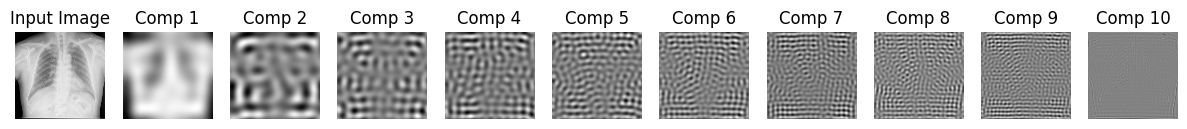

In [ ]:
# Load the image (for example)
image = cv2.imread("/content/dataset/images/CHNCXR_0001_0.png")
components = transformer_function(image)

# Visualize the components
visualize_transformed_components(image, components)


In [ ]:
def prepare_input_with_components(image):
    """
    Takes in an image, converts it to grayscale, and generates 10 EWT components.
    Returns a stacked array of 10 channels (the EWT components).
    """
    # Convert image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Generate EWT components using the previously defined functions
    ppff = ppfft(gray_image)
    meanppff = np.fft.fftshift(np.mean(np.abs(ppff), axis=1))
    points = [10, 15, 20, 25, 30, 35, 40, 45, 50]
    num = np.asarray(points) * np.pi
    points = num / np.round(len(meanppff) / 2)

    H, W = gray_image.shape
    mfb = ewt2d_LPFilterbank(points, H, W)

    # Apply filters to get the 10 EWT components
    ff = np.fft.fft2(gray_image)
    ewtLP = [None] * len(mfb)
    for k in range(len(mfb)):
        ewtLP[k] = np.real(np.fft.ifft2(np.conj(mfb[k]) * ff))

    # Return only the EWT components
    return np.array(ewtLP)  # Shape: (10, H, W)


In [ ]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model

def conv_block(input_tensor, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(input_tensor, num_filters):
    x = conv_block(input_tensor, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(input_tensor, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input_tensor)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="U-Net")
    return model

# Change the input shape to (512, 512, 10) to match the new data format
model = build_unet((512, 512, 10))

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)  # Adjust the learning rate here
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])  # Update as needed



NameError: name 'tf' is not defined

In [ ]:
# Print the model summary to confirm the architecture
#model.summary()


In [ ]:
def data_generator(image_paths, mask_paths, batch_size):
    while True:
        batch_images = []
        batch_masks = []

        for i in range(batch_size):
            image = cv2.imread(image_paths[i])
            mask = cv2.imread(mask_paths[i], cv2.IMREAD_GRAYSCALE)

            # Prepare only the EWT components
            ewt_components = prepare_input_with_components(image)

            # Make sure to transpose to the correct shape (10, H, W) if necessary
            batch_images.append(ewt_components)
            batch_masks.append(mask)

        batch_images = np.array(batch_images)  # Shape: (batch_size, 10, H, W)
        batch_masks = np.array(batch_masks)    # Shape: (batch_size, H, W)

        yield batch_images, batch_masks


**Process Flow:**

Data Preparation: Ensure your dataset is split into training, validation, and testing sets. This helps in evaluating your model's performance.

Data Augmentation: If your dataset is small, consider applying data augmentation techniques to increase diversity. This can help improve model generalization.

Normalization: Make sure the input images (the 10 components) are normalized. This typically involves scaling pixel values to a range (e.g., 0 to 1).

Model Compilation: Ensure that the model is compiled with an appropriate loss function and optimizer. For segmentation tasks, you might use binary cross-entropy for a binary mask or categorical cross-entropy for multi-class segmentation.

Set Up Callbacks: Implement callbacks for early stopping and model checkpointing. This allows you to save the best model and prevent overfitting.

Training: Finally, prepare the training loop to fit the model on your data.

In [ ]:
def reshape_to_target(image, target_shape):
    # Ensure the image has the right number of dimensions
    if image.ndim == 2:  # If it's grayscale (H, W)
        image = np.expand_dims(image, axis=-1)  # Add channel dimension
    if image.shape[0] != target_shape[0] or image.shape[1] != target_shape[1]:
        image = cv2.resize(image, (target_shape[1], target_shape[0]))  # Resize to (H, W)
    if target_shape[-1] == 10:  # For 10-channel images
        image = np.repeat(image, 10, axis=-1)  # Repeat for channels
    return image

In [ ]:
# import os
# import numpy as np
# import tensorflow as tf
# from tensorflow.keras.utils import Sequence
# from tensorflow.keras.preprocessing.image import img_to_array, load_img

# class DataGenerator(Sequence):
#     def __init__(self, image_dir, mask_dir, batch_size=32, image_size=(512, 512), num_images=None, shuffle=True):
#         self.image_dir = image_dir
#         self.mask_dir = mask_dir
#         self.batch_size = batch_size
#         self.image_size = image_size
#         self.shuffle = shuffle

#         # Load your filenames
#         self.image_filenames = os.listdir(image_dir)
#         self.mask_filenames = os.listdir(mask_dir)

#         if num_images is not None:
#             self.image_filenames = self.image_filenames[:num_images]
#             self.mask_filenames = self.mask_filenames[:num_images]

#         self.on_epoch_end()  # Shuffle if needed
#         super().__init__()  # Call the parent constructor

#     def __len__(self):
#         return int(np.floor(len(self.image_filenames) / self.batch_size))

#     def __getitem__(self, index):
#         # Generate one batch of data
#         indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
#         batch_images = [self.image_filenames[i] for i in indices]
#         batch_masks = [self.mask_filenames[i] for i in indices]

#         X, y = self.__data_generation(batch_images, batch_masks)
#         return X, y

#     def on_epoch_end(self):
#         # Shuffle the data after each epoch if desired
#         self.indices = np.arange(len(self.image_filenames))
#         np.random.shuffle(self.indices)

#     def __data_generation(self, batch_images, batch_masks):
#         X = np.empty((self.batch_size, 512, 512, 10))  # 10 channels for X-ray images
#         y = np.empty((self.batch_size, 512, 512, 1))   # 1 channel for masks

#         for i, (img_file, mask_file) in enumerate(zip(batch_images, batch_masks)):
#             # Load the image and resize to (512, 512)
#             img_path = os.path.join(self.image_dir, img_file)
#             image = cv2.imread(img_path)
#             image = cv2.resize(image, (512, 512))  # Resize to (512, 512)

#             # Generate the EWT components
#             image_components = prepare_input_with_components(image)  # Now has shape (10, 512, 512)

#             # Transpose to match (512, 512, 10) and assign
#             X[i] = np.transpose(image_components, (1, 2, 0))

#             # Load and reshape the mask
#             mask_path = os.path.join(self.mask_dir, mask_file)
#             mask = load_img(mask_path, color_mode='grayscale', target_size=(512, 512))
#             mask = img_to_array(mask)  # Shape: (512, 512, 1)

#             y[i] = mask  # Assign mask

#         return X, y


import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import cv2  # Ensure you have this imported

class DataGenerator(Sequence):
    def __init__(self, image_dir, mask_dir, batch_size=32, image_size=(512, 512), num_images=None, shuffle=True):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle

        # Load your filenames
        self.image_filenames = os.listdir(image_dir)
        self.mask_filenames = os.listdir(mask_dir)

        if num_images is not None:
            self.image_filenames = self.image_filenames[:num_images]
            self.mask_filenames = self.mask_filenames[:num_images]

        self.on_epoch_end()  # Shuffle if needed
        super().__init__()  # Call the parent constructor

    def __len__(self):
        return int(np.floor(len(self.image_filenames) / self.batch_size))

    def __getitem__(self, index):
        # Generate one batch of data
        indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_images = [self.image_filenames[i] for i in indices]
        batch_masks = [self.mask_filenames[i] for i in indices]

        X, y = self.__data_generation(batch_images, batch_masks)
        return X, y

    def on_epoch_end(self):
        # Shuffle the data after each epoch if desired
        self.indices = np.arange(len(self.image_filenames))
        np.random.shuffle(self.indices)

    def __data_generation(self, batch_images, batch_masks):
        X = np.empty((self.batch_size, 512, 512, 10))  # 10 channels for X-ray images
        y = np.empty((self.batch_size, 512, 512, 1))   # 1 channel for masks

        for i, (img_file, mask_file) in enumerate(zip(batch_images, batch_masks)):
            # Load the image and resize to (512, 512)
            img_path = os.path.join(self.image_dir, img_file)
            image = cv2.imread(img_path)
            image = cv2.resize(image, (512, 512))  # Resize to (512, 512)

            # Generate the EWT components
            image_components = prepare_input_with_components(image)  # Now has shape (10, 512, 512)

            # Transpose to match (512, 512, 10) and assign
            X[i] = np.transpose(image_components, (1, 2, 0))

            # Load and reshape the mask
            mask_path = os.path.join(self.mask_dir, mask_file)
            mask = load_img(mask_path, color_mode='grayscale', target_size=(512, 512))
            mask = img_to_array(mask)  # Shape: (512, 512, 1)
            mask = mask.astype(np.float32) / 255.0  # Normalize mask to [0, 1]

            y[i] = mask  # Assign mask

        # Normalize X to [0, 1]
        X = X.astype(np.float32) / 255.0  # Normalize input images to [0, 1]

        return X, y


In [ ]:
# image_dir = '/dataset/images'
# mask_dir = '/dataset/masks'

# # Create a data generator
# train_generator = DataGenerator(image_dir, mask_dir, batch_size=8)


In [ ]:
# Define paths for your images and masks
image_directory = 'dataset/images/'  # Replace with your actual image path
mask_directory = 'dataset/masks/'      # Replace with your actual mask path

# Define parameters for your DataGenerator
batch_size = 2
image_size = (512, 512)  # Change if your images are a different size
num_images = 100  # Use only 50 images for this run

# Create an instance of your DataGenerator
train_data_generator = DataGenerator(image_directory, mask_directory,
                                     batch_size=batch_size,
                                     image_size=image_size,
                                     num_images=num_images)




In [ ]:
history = model.fit(train_data_generator,
                    steps_per_epoch=len(train_data_generator) // batch_size,
                    epochs=5)

In [ ]:
def prepare_input_with_components(image):
    """
    Takes in a grayscale image and generates 10 EWT components.
    Returns a stacked array of 10 channels (the EWT components).
    """
    # Ensure the image is in the right shape
    if image.ndim == 3 and image.shape[2] == 1:  # If it's (512, 512, 1)
        image = image[:, :, 0]  # Convert to (512, 512)

    # Proceed to generate EWT components
    H, W = image.shape
    ppff = ppfft(image)
    meanppff = np.fft.fftshift(np.mean(np.abs(ppff), axis=1))
    points = [10, 15, 20, 25, 30, 35, 40, 45, 50]
    num = np.asarray(points) * np.pi
    points = num / np.round(len(meanppff) / 2)

    mfb = ewt2d_LPFilterbank(points, H, W)

    # Apply filters to get the 10 EWT components
    ff = np.fft.fft2(image)
    ewtLP = [np.real(np.fft.ifft2(np.conj(mfb[k]) * ff)) for k in range(len(mfb))]

    # Return the EWT components
    return np.array(ewtLP)  # Shape: (10, H, W)


1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


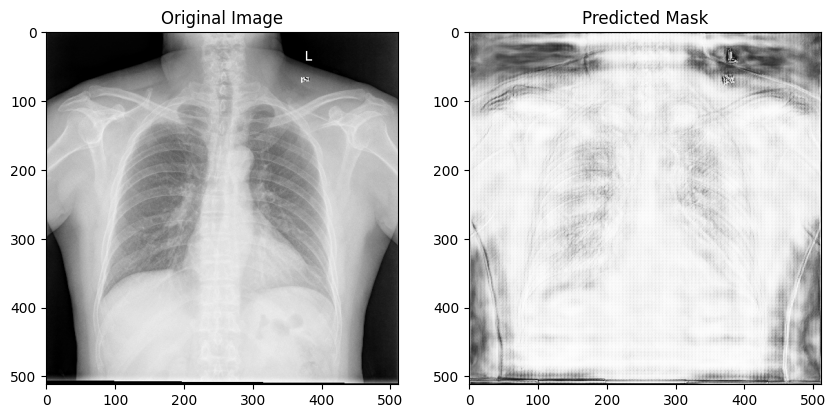

In [ ]:
import matplotlib.pyplot as plt

# Function to visualize predictions
def visualize_prediction(model, image_path):
    # Load and preprocess the image (including EWT components)
    image = load_img(image_path, color_mode='grayscale', target_size=(512, 512))
    image = img_to_array(image)

    # Generate EWT components
    image_components = prepare_input_with_components(image)  # This should return (10, 512, 512)
    image_components = np.transpose(image_components, (1, 2, 0))  # Reshape to (512, 512, 10)
    image_components = np.expand_dims(image_components, axis=0)  # Add batch dimension (1, 512, 512, 10)

    # Get the model's prediction
    predicted_mask = model.predict(image_components)

    # Reshape the predicted mask to (512, 512)
    predicted_mask = predicted_mask[0, :, :, 0]  # Remove batch and channel dimensions

    # Display the image and predicted mask side by side
    plt.figure(figsize=(10, 5))

    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title('Original Image')

    # Predicted mask
    plt.subplot(1, 2, 2)
    plt.imshow(predicted_mask, cmap='gray')
    plt.title('Predicted Mask')

    plt.show()

# Provide a path to an image from your dataset
image_path = "/content/dataset/images/CHNCXR_0002_0.png"
visualize_prediction(model, image_path)


In [ ]:
# Fit the model
history = model.fit(train_data_generator,
                    steps_per_epoch=len(train_data_generator) // batch_size,
                    epochs=5)

Epoch 1/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 146s 59s/step - accuracy: 0.2769 - loss: -52.8487
Epoch 2/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 117s 59s/step - accuracy: 0.5049 - loss: -246.6026
Epoch 3/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 60s 34ms/step - accuracy: 0.5564 - loss: -268.2502
Epoch 4/5


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2/2 ━━━━━━━━━━━━━━━━━━━━ 128s 67s/step - accuracy: 0.5441 - loss: -377.0023
Epoch 5/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 121s 60s/step - accuracy: 0.5632 - loss: -288.2278


USING .npy :

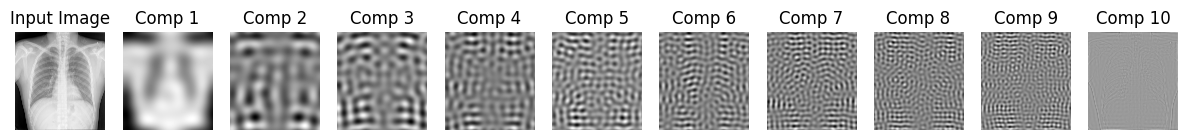

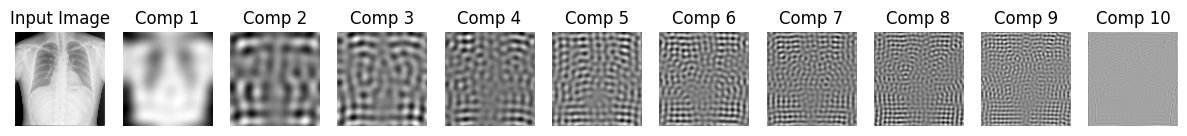

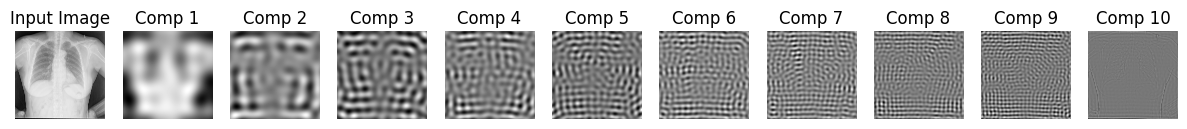

Displayed input and transformed images.


In [ ]:
# TO SHOW THE OUTPUT OF THE IMAGES TRANSFORMED
# input_dir = '/content/dataset/images'
# transformed_dir = '/content/dataset/transformed_images'
# # List input and transformed files (assuming file names match between input and output)
# input_images = sorted([f for f in os.listdir(input_dir) if f.endswith(('.png'))])[37:40]  # First 2 images
# transformed_files = sorted([f for f in os.listdir(transformed_dir) if f.endswith('.npy')])[37:40]  # First 2 transformed sets

# # Loop through the first 2 images
# for input_image, transformed_file in zip(input_images, transformed_files):
#     # Load the input image
#     input_img = cv2.imread(os.path.join(input_dir, input_image))
#     input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for displaying

#     # Load the transformed components
#     transformed_components = np.load(os.path.join(transformed_dir, transformed_file))

#     # Create a figure to display the input and its components
#     plt.figure(figsize=(15, 5))

#     # Show the original input image
#     plt.subplot(1, 11, 1)
#     plt.imshow(input_img)
#     plt.title('Input Image')
#     plt.axis('off')

#     # Show the 10 transformed components side by side
#     for i in range(10):
#         plt.subplot(1, 11, i+2)
#         plt.imshow(transformed_components[i], cmap='gray')
#         plt.title(f'Comp {i+1}')
#         plt.axis('off')

#     plt.show()

# print("Displayed input and transformed images.")